## Importing necessary libraries

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
import os

## Utility Functions


In [118]:
def draw_rounded_rect(img, bbox, line_color=(255, 255, 255), ellipse_color=(0, 0, 255), line_thickness=2,
                      ellipse_thickness=3, radius=15):
    """ Draw a rectangle with rounded corners, allowing separate colors and thicknesses for lines and ellipses. """
    x1, y1, x2, y2 = bbox

    # Draw straight lines between corner circles (rectangular part)
    cv.line(img, (x1 + radius, y1), (x2 - radius, y1), line_color, line_thickness)
    cv.line(img, (x1 + radius, y2), (x2 - radius, y2), line_color, line_thickness)
    cv.line(img, (x1, y1 + radius), (x1, y2 - radius), line_color, line_thickness)
    cv.line(img, (x2, y1 + radius), (x2, y2 - radius), line_color, line_thickness)

    # Draw arcs at the corners (ellipse part)
    cv.ellipse(img, (x1 + radius, y1 + radius), (radius, radius), 180, 0, 90, ellipse_color, ellipse_thickness)  # Top-left corner
    cv.ellipse(img, (x2 - radius, y1 + radius), (radius, radius), 270, 0, 90, ellipse_color, ellipse_thickness)  # Top-right corner
    cv.ellipse(img, (x1 + radius, y2 - radius), (radius, radius), 90, 0, 90, ellipse_color, ellipse_thickness)   # Bottom-left corner
    cv.ellipse(img, (x2 - radius, y2 - radius), (radius, radius), 0, 0, 90, ellipse_color, ellipse_thickness)     # Bottom-right corner


def draw_text_with_bg(frame, text, pos, font=cv.FONT_HERSHEY_SIMPLEX, font_scale=0.3, thickness=1, bg_color=(255, 255, 255),
                      text_color=(0, 0, 0)):
    """ Draws text with a background rectangle. """
    (text_width, text_height), baseline = cv.getTextSize(text, font, font_scale, thickness)
    x, y = pos
    cv.rectangle(frame, (x, y - text_height - baseline), (x + text_width, y + baseline), bg_color, cv.FILLED)
    cv.putText(frame, text, (x, y), font, font_scale, text_color, thickness, lineType=cv.LINE_AA)

# Face Cascade

## Detecting faces from images

Facial regions detected at (275, 141, 528, 394)


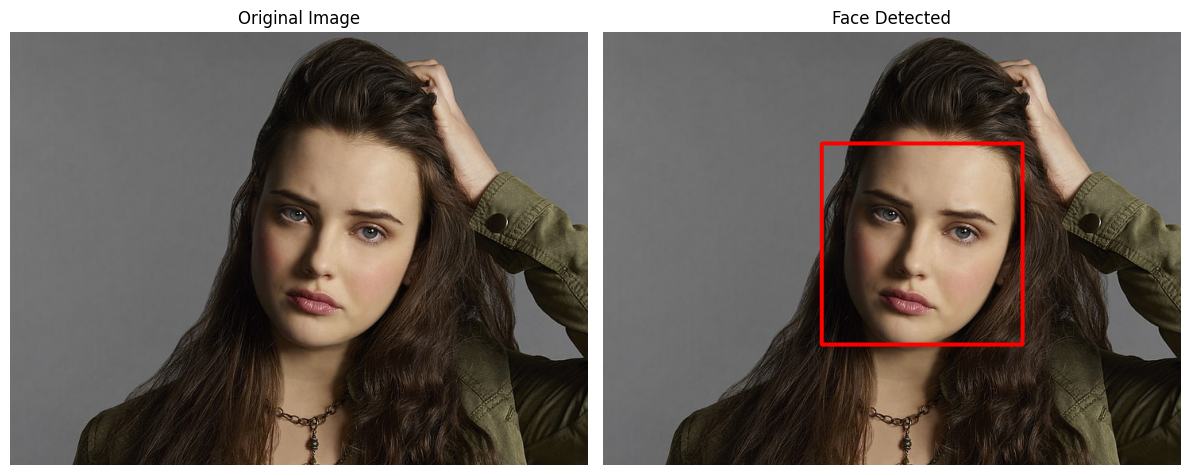

In [4]:

# Load the face cascade
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_face(image_path, save_fig = False, filename = None):
    # Read the image
    img = cv.imread(image_path)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_rgb_copy = img_rgb.copy()  # Copy the RGB image for original display

    # Detect faces in the image
    face_coords = face_cascade.detectMultiScale(img_gray, 
                                                scaleFactor=1.1,
                                                minNeighbors=5,
                                                minSize=(30, 30))

    # Check if any faces were detected
    if len(face_coords) > 0:
        # Draw rectangles around detected faces
        for (x, y, w, h) in face_coords:
            cv.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 0, 0), 4)
            print(f"Facial regions detected at ({x}, {y}, {x+w}, {y+h})")
    else:
        print("Couldn't detect face in the image")

    # Plot the original image and the image with face detection (if any)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_rgb_copy)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(img_rgb)
    ax[1].set_title('Face Detected' if len(face_coords) > 0 else 'No Face Detected')
    ax[1].axis('off')

    if save_fig and filename:
        file_path = os.path.join("DATA/IMAGES/detected_images", filename)
        fig.savefig(file_path, bbox_inches = 'tight', dpi = 200)
    plt.tight_layout()
    plt.show()

img_file = "DATA/IMAGES/raw_images/katherine.jpg"
detect_face(img_file, save_fig=True, filename= "katherine_face.jpg")


Facial regions detected at (165, 13, 301, 149)
Facial regions detected at (242, 99, 407, 264)


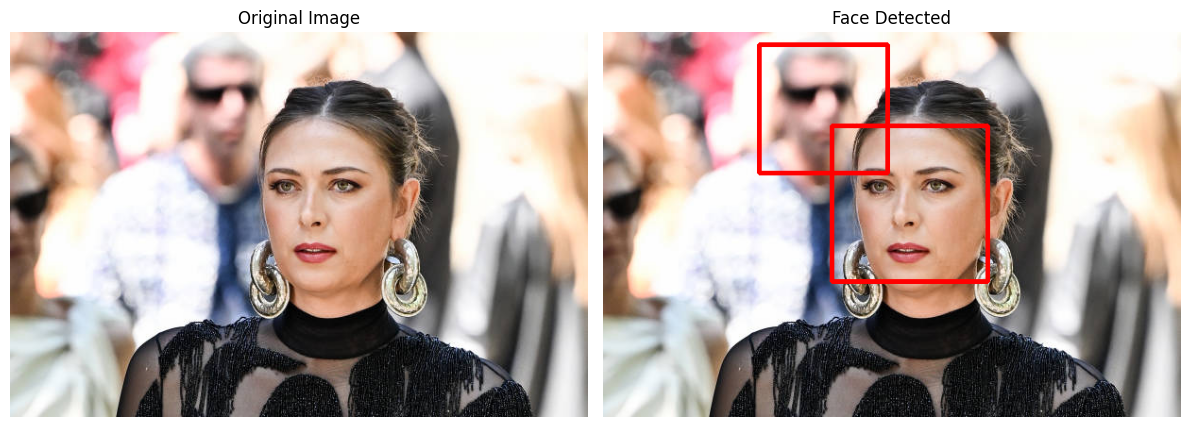

In [6]:
detect_face('DATA/IMAGES/raw_images/sarapova.jpg', save_fig=True, filename="sarapova_face.jpg")

Facial regions detected at (277, 86, 488, 297)


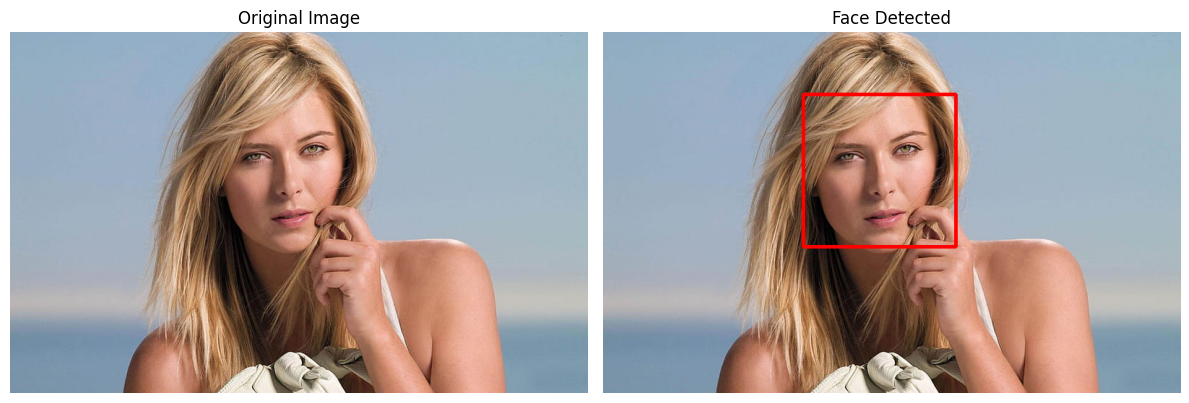

In [8]:
detect_face("DATA/IMAGES/raw_images/sarapova_1.jpg", save_fig=True, filename="sarapova_face_1.jpg")

Facial regions detected at (687, 265, 1429, 1007)
Facial regions detected at (1578, 1370, 1635, 1427)
Facial regions detected at (788, 2117, 844, 2173)
Facial regions detected at (1606, 1547, 1658, 1599)
Facial regions detected at (1548, 1275, 1601, 1328)
Facial regions detected at (678, 1520, 743, 1585)
Facial regions detected at (776, 2313, 833, 2370)
Facial regions detected at (1249, 1555, 1305, 1611)


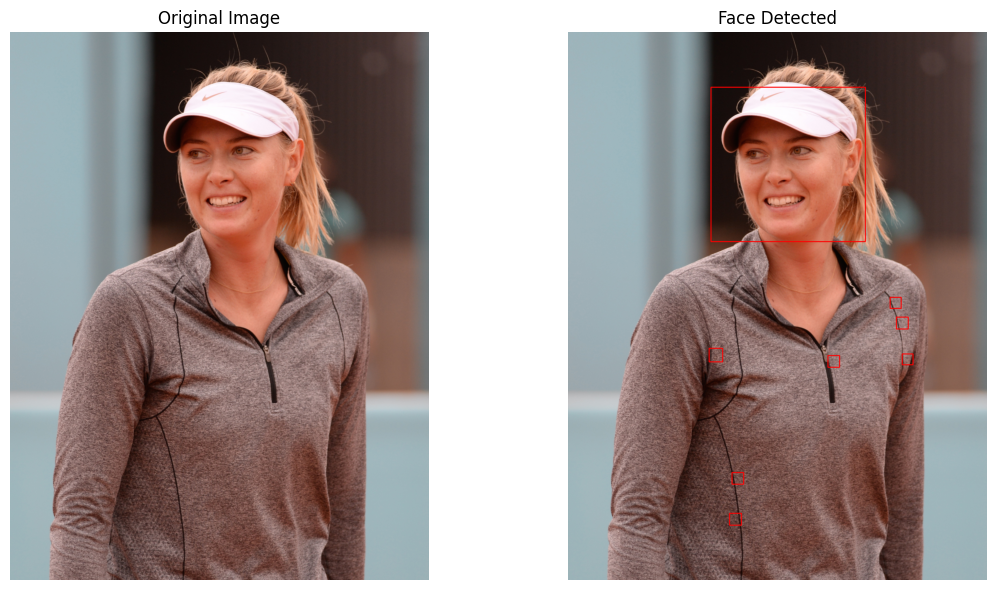

In [9]:
detect_face("DATA/IMAGES/raw_images/sarapova_2.jpg", save_fig=True, filename="sarapova_face_2.jpg")

Facial regions detected at (1501, 1022, 1583, 1104)
Facial regions detected at (1598, 1016, 1691, 1109)
Facial regions detected at (595, 345, 1035, 785)
Facial regions detected at (1433, 1141, 1542, 1250)
Facial regions detected at (1926, 989, 1984, 1047)


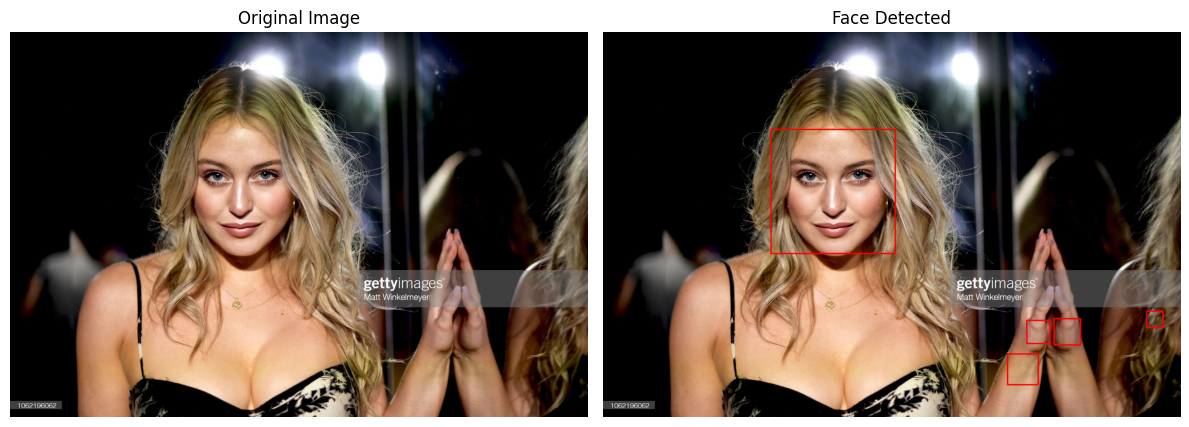

In [10]:
detect_face("DATA/IMAGES/raw_images/iskra.jpg")

### Drawing only the Largest Bounding Box

To address the issue of mistakenly detected regions that are not actual faces, we can filter the detected bounding boxes and only consider the largest one as the most likely facial region. This approach assumes that in an image where only one face is present (or even multiple), the largest bounding box is most likely to be the correct face detection, while smaller bounding boxes are more likely to be false positives.

Largest facial region detected at (687, 265, 1429, 1007)


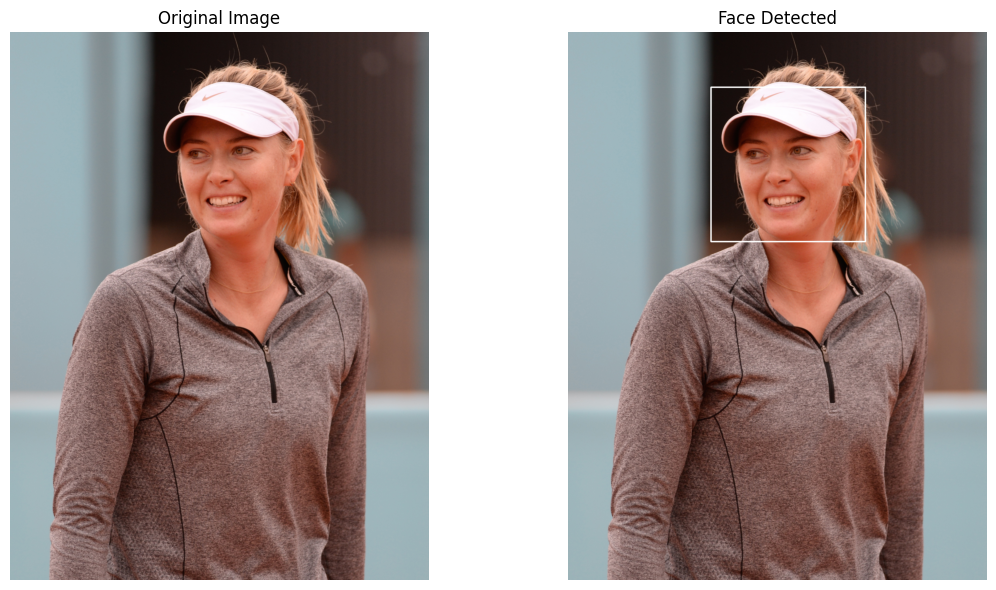

In [12]:
# Load the face cascade
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_face(image_path, save_fig=False, filename=None):
    # Read the image
    img = cv.imread(image_path)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_rgb_copy = img_rgb.copy()  # Copy the RGB image for original display

    # Detect faces in the image
    face_coords = face_cascade.detectMultiScale(img_gray, 
                                                scaleFactor=1.1,
                                                minNeighbors=5,
                                                minSize=(30, 30))

    # Check if any faces were detected
    if len(face_coords) > 0:
        # Find the largest bounding box by area (width * height)
        largest_face = max(face_coords, key=lambda rect: rect[2] * rect[3])
        x, y, w, h = largest_face
        cv.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 255, 255), 6)
        print(f"Largest facial region detected at ({x}, {y}, {x+w}, {y+h})")
    else:
        print("Couldn't detect face in the image")

    # Plot the original image and the image with face detection (if any)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_rgb_copy)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(img_rgb)
    ax[1].set_title('Face Detected' if len(face_coords) > 0 else 'No Face Detected')
    ax[1].axis('off')

    if save_fig and filename:
        file_path = os.path.join("DATA/IMAGES/detected_images", filename)
        fig.savefig(file_path, bbox_inches='tight', dpi=200)
    plt.tight_layout()
    plt.show()

# Example usage
img_file = "DATA/IMAGES/raw_images/sarapova_2.jpg"
detect_face(img_file, save_fig=True, filename="sarapova_face_2_mod.jpg")


## Detect faces from videos

In [25]:
def detect_faces_from_video(video_path, scale_factor, min_neighbors, resize_factor, save_video=False, filename=None):
    """
    Detects faces in a video, filters them by checking for eyes, and optionally saves the output video.
    
    Parameters:
        video_path (str or int): Path to the video file or 0 for webcam.
        scale_factor (float): Parameter specifying the scaling factor for the face detection.
        min_neighbors (int): Parameter specifying the number of neighbors for detecting faces.
        resize_factor (float): Factor to resize the displayed video frames.
        save_video (bool): If True, the video with detected faces is saved.
        filename (str): The filename to save the processed video.
    """
    # Load the face and eye cascade classifiers
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')
    
    # Open the video capture object (from file or webcam)
    cap = cv.VideoCapture(0 if video_path == 0 else video_path)
    
    if not cap.isOpened():
        raise Exception("Error: Unable to open the video file or webcam.")
    
    # Get video properties (frame width, height, and FPS)
    f_w, f_h = (int(cap.get(x)) for x in (cv.CAP_PROP_FRAME_WIDTH, cv.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv.CAP_PROP_FPS)) if video_path != 0 else 25

    video_dir = "DATA/VIDEOS/detected_videos"
    output = None
    
    # Prepare to save the output video if required
    if save_video and filename:
        os.makedirs(video_dir, exist_ok=True)
        save_video_path = os.path.join(video_dir, filename)
        fourcc = cv.VideoWriter_fourcc(*"mp4v")
        output = cv.VideoWriter(save_video_path, fourcc, fps, (f_w, f_h))

    try:
        # Process the video frame by frame
        while cap.isOpened():
            ret, frame = cap.read()
            
            # If no frame is returned, break the loop
            if not ret:
                break

            # Convert the frame to grayscale for face detection
            frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

            # Detect faces in the grayscale frame
            face_coords = face_cascade.detectMultiScale(image=frame_gray, 
                                                        scaleFactor=scale_factor, 
                                                        minNeighbors=min_neighbors)
            
            # If faces are detected, process each face
            if len(face_coords) > 0:
                face_count = 1
                for (x, y, w, h) in face_coords:
                    roi_gray = frame_gray[y:y+h, x:x+w]  # Region of interest for detecting eyes
                    bbox = (x, y, x+w, y+h)

                    # Detect eyes within the detected face
                    eye_coords = eye_cascade.detectMultiScale(roi_gray)

                    # Only consider regions with at least two detected eyes as valid faces
                    if len(eye_coords) >= 2:
                        # Draw a rounded rectangle around the face and add a label
                        draw_rounded_rect(frame, bbox, ellipse_color=(0, 255, 0))
                        label = f"Face {face_count}"
                        draw_text_with_bg(frame, label, (x, y-10), font_scale=1, thickness=2, bg_color=(0, 0, 0), text_color=(0, 255, 0))
                        face_count += 1

            # If saving the video, write the frame with the detected faces
            if save_video:
                output.write(frame)

            # Resize the frame for display
            resized_frame = cv.resize(frame, (int(resize_factor * frame.shape[1]), int(resize_factor * frame.shape[0])))
            cv.imshow('Video', resized_frame)

            # Press 'p' to stop the video
            if cv.waitKey(1) & 0xFF == ord('p'):
                break
    except Exception as e:
        print(f"Error occurred during video processing: {str(e)}")
    finally:
        # Release the resources properly
        cap.release()
        if save_video and output:
            output.release()
        cv.destroyAllWindows()
        print("Video processing completed, resources released.")


# Example usage
video_path = "https://videos.pexels.com/video-files/3209298/3209298-uhd_2560_1440_25fps.mp4"
file_name = "face_detection_1.mp4"

detect_faces_from_video(video_path, 1.1, 5, 0.5, save_video=True, filename=file_name)


Video processing completed, resources released.


## Face and eye detection

Number of facial regions detected is 1

Facial region 1 detected at (275, 141, 528, 394)

Number of eye features detected in this region is 3
Eye features 1 detected at (57, 62, 115, 120) for facial region 1 at (275, 141, 528, 394)
Eye features 2 detected at (72, 167, 136, 231) for facial region 1 at (275, 141, 528, 394)
Eye features 3 detected at (148, 84, 203, 139) for facial region 1 at (275, 141, 528, 394)
Saved image with detections to DATA/IMAGES/detected_images\katherine_eye.jpg


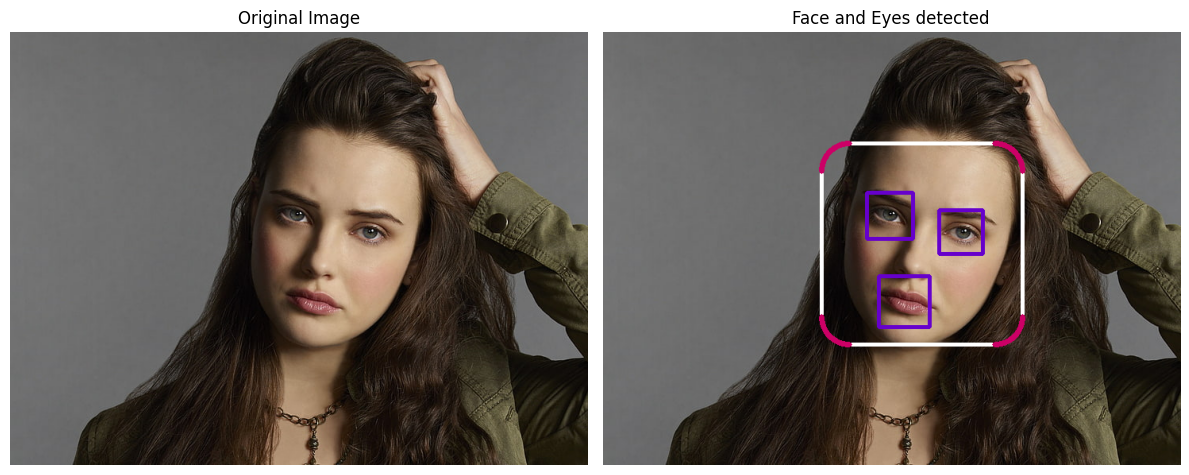

In [83]:

def detect_face_and_eye(image_path, save_fig=False, filename=None):
    try:
        # Load Haar cascades for eyes
        eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')
        if eye_cascade.empty():
            raise Exception("Error loading eye cascade classifier!")

        # Load the image
        img = cv.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image at {image_path}")

        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_rgb_copy = img_rgb.copy()
        thickness = max(1, int(img.shape[1] / 200)) 

        # Load face cascade and detect faces
        face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
        if face_cascade.empty():
            raise Exception("Error loading face cascade classifier!")

        face_coords = face_cascade.detectMultiScale(img_gray, 
                                                    scaleFactor=1.1,
                                                    minNeighbors=5,
                                                    minSize=(30, 30))

        print(f"Number of facial regions detected is {len(face_coords)}")
        
        if len(face_coords) > 0:
            count_face = 1
            for (x, y, w, h) in face_coords:
                try:
                    print(f"\nFacial region {count_face} detected at ({x}, {y}, {x+w}, {y+h})")
                    bbox = (x, y, x+w, y+h)

                    # Eyes detection within the facial region
                    roi_gray = img_gray[y:y+h, x:x+w]
                    roi_color = img_rgb[y:y+h, x:x+w]

                    eyes_coords = eye_cascade.detectMultiScale(roi_gray)

                    print(f"\nNumber of eye features detected in this region is {len(eyes_coords)}")

                    if len(eyes_coords) >= 2:
                        count_eyes = 1
                        for (ex, ey, ew, eh) in eyes_coords:
                            draw_rounded_rect(img_rgb, bbox, ellipse_color=(204, 0, 102), line_thickness=thickness,
                                              ellipse_thickness=thickness+2, radius=35)
                            cv.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (102, 0, 204), thickness)
                            print(f"Eye features {count_eyes} detected at ({ex}, {ey}, {ex+ew}, {ey+eh}) for facial region {count_face} at ({x}, {y}, {x+w}, {y+h})")
                            count_eyes += 1
                    else:
                        print(f"Couldn't detect eyes in facial region {count_face} at ({x}, {y}, {x+w}, {y+h})")

                    count_face += 1

                except Exception as e:
                    print(f"Error processing facial region {count_face}: {e}")

        else:
            image_name = image_path.split('\\')[-1]
            print(f"Couldn't detect face for the {image_name}")

        # Plot the original image and the image with face detection (if any)
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img_rgb_copy)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(img_rgb)
        ax[1].set_title('Face and Eyes detected' if len(face_coords) > 0 else 'No Face Detected')
        ax[1].axis('off')

        if save_fig and filename:
            try:
                # Ensure the folder exists
                save_dir = "DATA/IMAGES/detected_images"
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                    
                filepath = os.path.join(save_dir, filename)
                fig.savefig(filepath, bbox_inches='tight', dpi=200)
                print(f"Saved image with detections to {filepath}")
            except Exception as e:
                print(f"Error saving file: {e}")

        plt.tight_layout()
        plt.show()

    except FileNotFoundError as fnf_error:
        print(f"File not found: {fnf_error}")
    except Exception as e:
        print(f"An error occurred: {e}")


# Call the function
detect_face_and_eye("DATA/IMAGES/raw_images/katherine.jpg", save_fig=True, filename="katherine_eye.jpg")


Number of facial regions deected is 1 

Facial region 1 detected at (277, 86, 488, 297)

Number of eye features detected in this region is 3 
Eye features 1 detected at (117, 54, 161, 98) for facial region 1 at (277, 86, 488, 297)
Eye features 2 detected at (37, 66, 81, 110) for facial region 1 at (277, 86, 488, 297)
Eye features 3 detected at (149, 158, 200, 209) for facial region 1 at (277, 86, 488, 297)


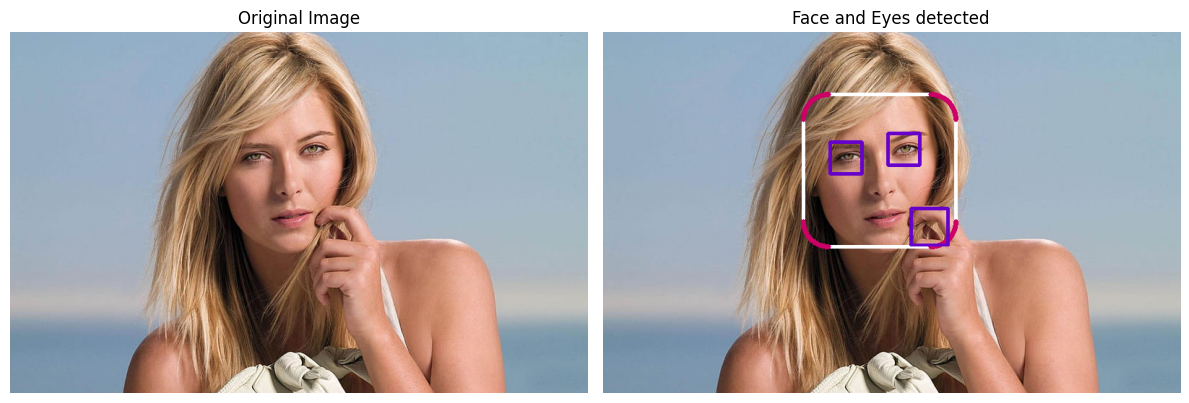

In [76]:
detect_face_and_eye("DATA/IMAGES/raw_images/sarapova_1.jpg")

Number of facial regions deected is 1 

Facial region 1 detected at (315, 61, 483, 229)

Number of eye features detected in this region is 2 
Eye features 1 detected at (95, 60, 121, 86) for facial region 1 at (315, 61, 483, 229)
Eye features 2 detected at (31, 44, 74, 87) for facial region 1 at (315, 61, 483, 229)


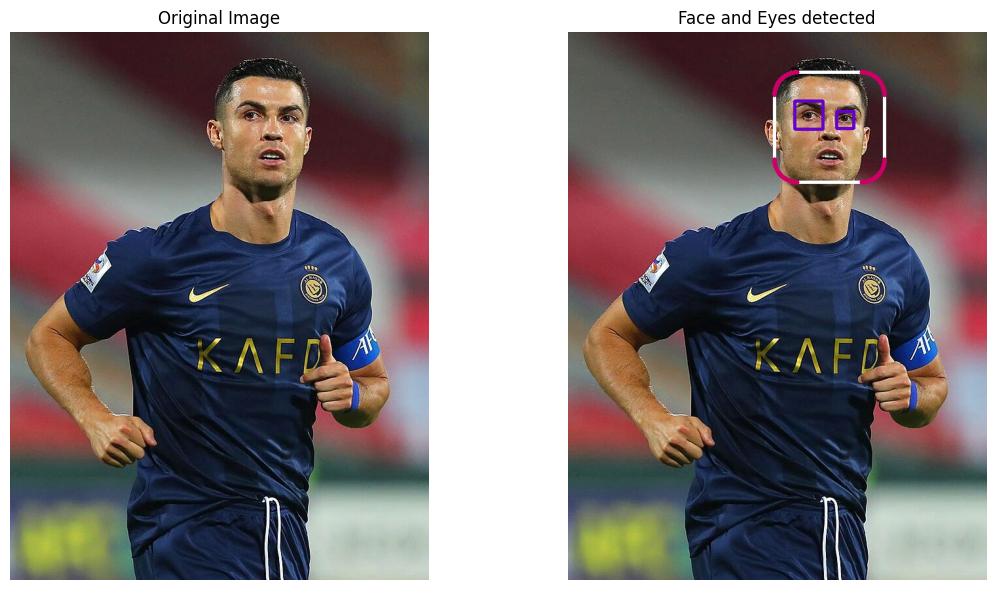

In [49]:
detect_face_and_eye("DATA/IMAGES/raw_images/ronaldo.jpg", save_fig=True, filename="ronaldo_eyes.jpg")

Number of facial regions deected is 1 

Facial region 1 detected at (686, 207, 1220, 741)

Number of eye features detected in this region is 2 
Eye features 1 detected at (112, 156, 223, 267) for facial region 1 at (686, 207, 1220, 741)
Eye features 2 detected at (276, 155, 395, 274) for facial region 1 at (686, 207, 1220, 741)


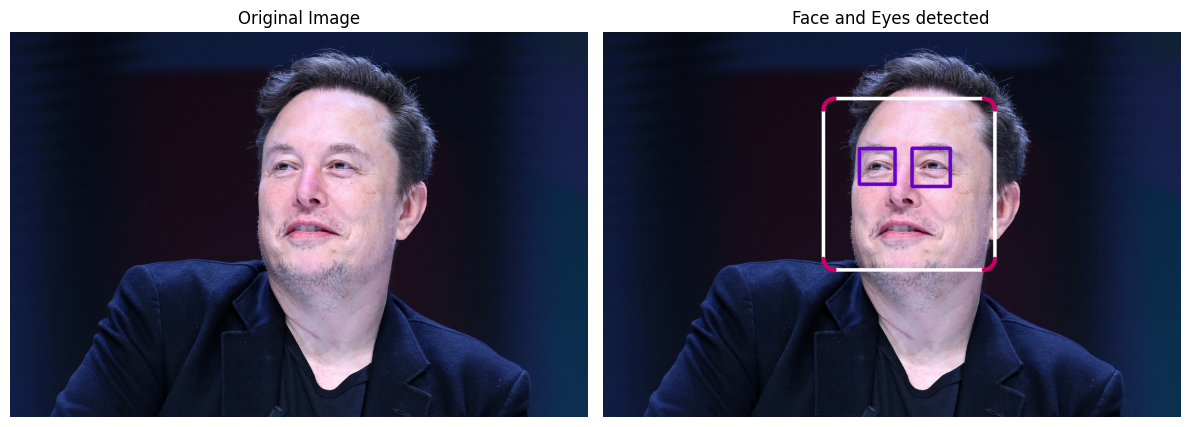

In [50]:
detect_face_and_eye("DATA/IMAGES/raw_images/elon.jpg", save_fig=True, filename="elon_eyes.jpg")

Number of facial regions deected is 1 

Facial region 1 detected at (169, 109, 435, 375)

Number of eye features detected in this region is 2 
Eye features 1 detected at (151, 81, 202, 132) for facial region 1 at (169, 109, 435, 375)
Eye features 2 detected at (62, 77, 115, 130) for facial region 1 at (169, 109, 435, 375)


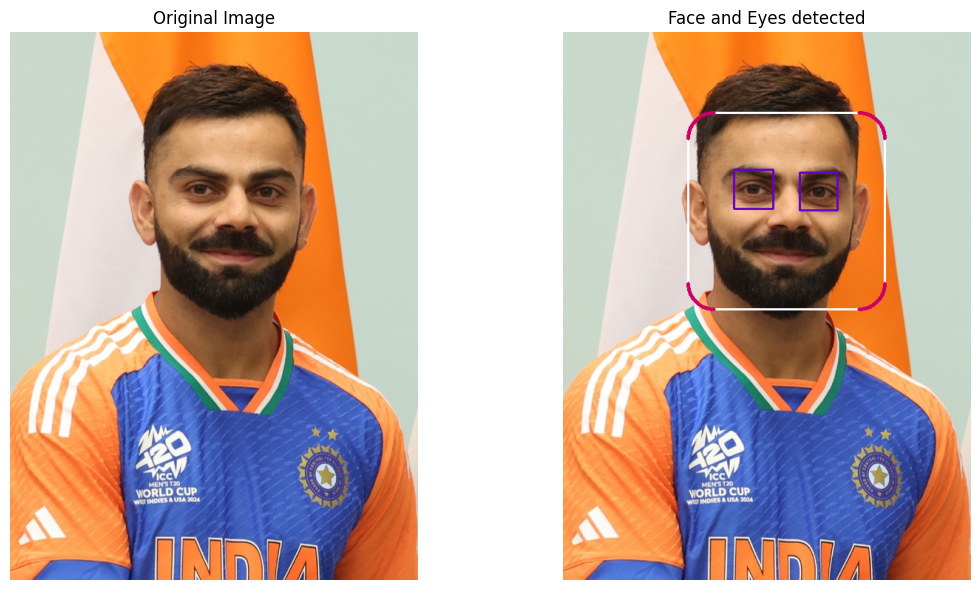

In [82]:
detect_face_and_eye("DATA/IMAGES/raw_images/virat_1.jpg")

Number of facial regions deected is 7 

Facial region 1 detected at (1435, 1079, 1681, 1325)

Number of eye features detected in this region is 3 
Eye features 1 detected at (151, 96, 187, 132) for facial region 1 at (1435, 1079, 1681, 1325)
Eye features 2 detected at (164, 99, 200, 135) for facial region 1 at (1435, 1079, 1681, 1325)
Eye features 3 detected at (65, 70, 111, 116) for facial region 1 at (1435, 1079, 1681, 1325)

Facial region 2 detected at (1194, 1106, 1495, 1407)

Number of eye features detected in this region is 3 
Eye features 1 detected at (60, 71, 133, 144) for facial region 2 at (1194, 1106, 1495, 1407)
Eye features 2 detected at (185, 102, 239, 156) for facial region 2 at (1194, 1106, 1495, 1407)
Eye features 3 detected at (77, 64, 169, 156) for facial region 2 at (1194, 1106, 1495, 1407)

Facial region 3 detected at (833, 1081, 1290, 1538)

Number of eye features detected in this region is 2 
Eye features 1 detected at (89, 129, 188, 228) for facial region 3 at 

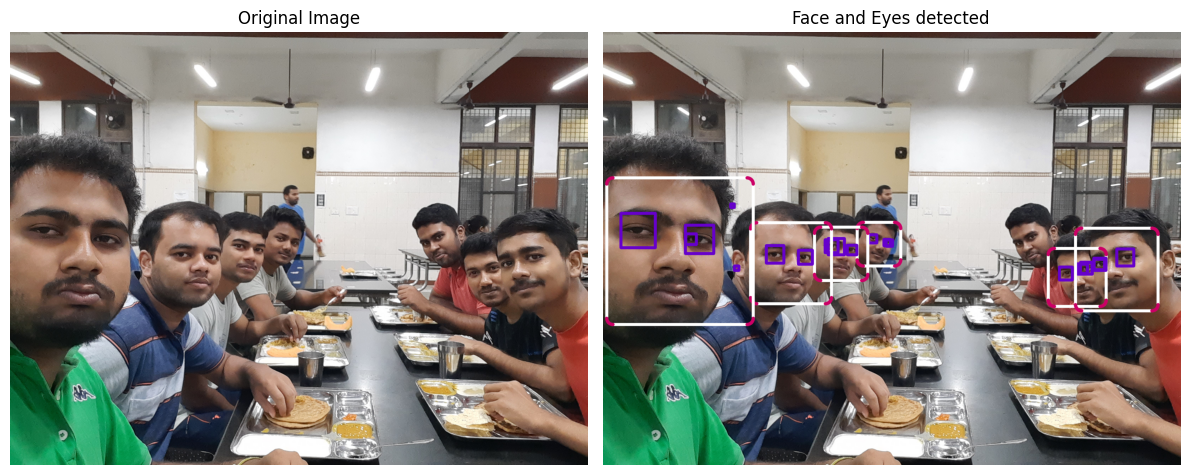

In [51]:
detect_face_and_eye("DATA/IMAGES/raw_images/group_selfie.jpg")

### Attempting to draw the bounding boxes around the eyes only within the facial region

To ensure we're only detecting and drawing bounding boxes for the eyes (instead of other facial regions like lips or eyebrows), we can filter the detected eye regions by their relative vertical positions. Specifically, if the centers of two detected eye bounding boxes lie within a specified vertical limit (e.g., ±50 pixels), we can confirm that they are likely eyes.

Here are the steps that were followed to achieve this:

**Approach**:
1. After detecting all eye regions within the face (eyes_coords), calculate the centers of the bounding boxes for the detected eyes.

2. Compare the vertical positions of the centers of each pair of detected eye bounding boxes. If the difference in their vertical positions is within a set range (e.g., ±20 pixels), assume these are valid eye detections.
3. Draw bounding boxes for only those pairs of eye regions that meet this condition.


Number of facial regions detected is 1

Facial region 1 detected at (275, 141, 528, 394)

Number of eye features detected in this region is 3
Eye features 1 detected at (148, 84, 203, 139) for facial region 1 at (275, 141, 528, 394)
Eye features 2 detected at (57, 62, 115, 120) for facial region 1 at (275, 141, 528, 394)
Saved image with detections to DATA/IMAGES/detected_images\katherine_eye_1.jpg


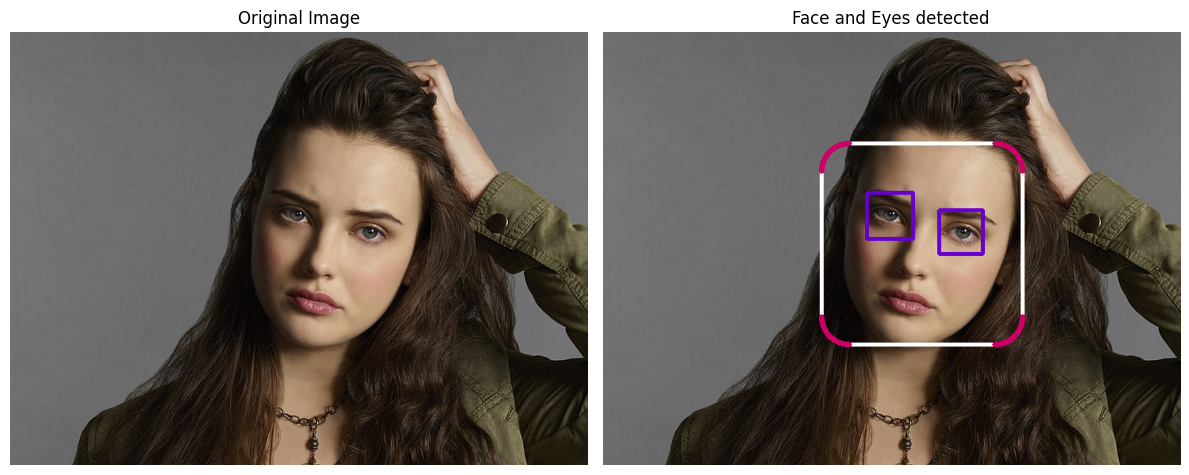

In [77]:
def detect_face_and_eye_1(image_path, save_fig=False, filename=None):
    try:
        # Load Haar cascade for eyes
        eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')
        if eye_cascade.empty():
            raise Exception("Error loading eye cascade classifier!")

        # Load the image
        img = cv.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image at {image_path}")

        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_rgb_copy = img_rgb.copy()
        thickness = max(1, int(img.shape[1] / 200)) 

        # Define vertical limit for eye alignment
        vertical_limit = 50  # Change this as per the image

        # Load face cascade and detect faces
        face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
        if face_cascade.empty():
            raise Exception("Error loading face cascade classifier!")

        face_coords = face_cascade.detectMultiScale(img_gray, 
                                                    scaleFactor=1.1,
                                                    minNeighbors=5,
                                                    minSize=(30, 30))

        print(f"Number of facial regions detected is {len(face_coords)}")
        
        if len(face_coords) > 0:
            count_face = 1
            for (x, y, w, h) in face_coords:
                try:
                    print(f"\nFacial region {count_face} detected at ({x}, {y}, {x+w}, {y+h})")
                    bbox = (x, y, x+w, y+h)

                    # Eyes detection within the facial region
                    roi_gray = img_gray[y:y+h, x:x+w]
                    roi_color = img_rgb[y:y+h, x:x+w]

                    eyes_coords = eye_cascade.detectMultiScale(roi_gray)

                    print(f"\nNumber of eye features detected in this region is {len(eyes_coords)}")

                    valid_eye_pairs = []

                    # Only consider valid eye pairs based on their vertical alignment
                    if len(eyes_coords) >= 2:
                        eye_centers = [(ex + ew // 2, ey + eh // 2, (ex, ey, ew, eh)) for (ex, ey, ew, eh) in eyes_coords]

                        # Check pairwise combinations of eye bounding boxes
                        for i in range(len(eye_centers)):
                            for j in range(i+1, len(eye_centers)):
                                _, eye_i_y, eye_i_box = eye_centers[i]
                                _, eye_j_y, eye_j_box = eye_centers[j]

                                if abs(eye_i_y - eye_j_y) <= vertical_limit:
                                    # If the vertical difference is within the limit, consider as a valid pair
                                    valid_eye_pairs.append(eye_i_box)
                                    valid_eye_pairs.append(eye_j_box)

                        # Remove duplicates and draw bounding boxes for valid eye regions
                        valid_eye_pairs = list(set(valid_eye_pairs))

                        if valid_eye_pairs:
                            for count_eyes, (ex, ey, ew, eh) in enumerate(valid_eye_pairs, 1):
                                draw_rounded_rect(img_rgb, bbox, ellipse_color=(204, 0, 102),line_thickness=thickness, ellipse_thickness=thickness+2,  radius=35)
                                cv.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (102, 0, 204), thickness)
                                print(f"Eye features {count_eyes} detected at ({ex}, {ey}, {ex+ew}, {ey+eh}) for facial region {count_face} at ({x}, {y}, {x+w}, {y+h})")
                        else:
                            print(f"No valid eye pairs detected in facial region {count_face}.")
                    else:
                        print(f"Couldn't detect enough eyes in facial region {count_face} at ({x}, {y}, {x+w}, {y+h})")

                    count_face += 1

                except Exception as e:
                    print(f"Error processing facial region {count_face}: {e}")

        else:
            image_name = image_path.split('\\')[-1]
            print(f"Couldn't detect face for the {image_name}")

        # Plot the original image and the image with face detection (if any)
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img_rgb_copy)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(img_rgb)
        ax[1].set_title('Face and Eyes detected' if len(face_coords) > 0 else 'No Face Detected')
        ax[1].axis('off')

        if save_fig and filename:
            try:
                # Ensure the folder exists
                save_dir = "DATA/IMAGES/detected_images"
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                    
                filepath = os.path.join(save_dir, filename)
                fig.savefig(filepath, bbox_inches='tight', dpi=200)
                print(f"Saved image with detections to {filepath}")
            except Exception as e:
                print(f"Error saving file: {e}")

        plt.tight_layout()
        plt.show()

    except FileNotFoundError as fnf_error:
        print(f"File not found: {fnf_error}")
    except Exception as e:
        print(f"An error occurred: {e}")


# Call the function
detect_face_and_eye_1("DATA/IMAGES/raw_images/katherine.jpg", save_fig=True, filename="katherine_eye_1.jpg")



Number of facial regions deected is 1 

Facial region 1 detected at (277, 86, 488, 297)

Number of eye features detected in this region is 3 
Eye features 1 detected at (117, 54, 161, 98) for facial region 1 at (277, 86, 488, 297)
Eye features 2 detected at (37, 66, 81, 110) for facial region 1 at (277, 86, 488, 297)
Eye features 3 detected at (149, 158, 200, 209) for facial region 1 at (277, 86, 488, 297)


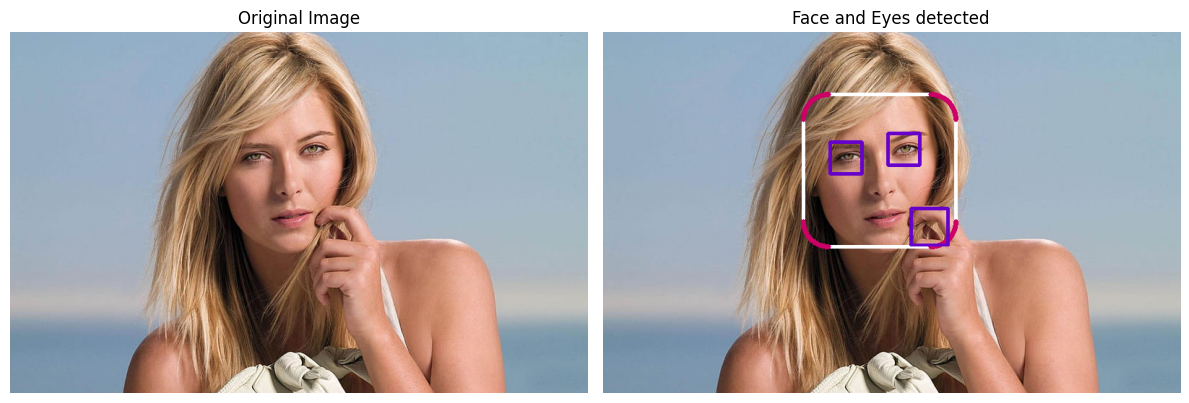

Number of facial regions detected is 1

Facial region 1 detected at (277, 86, 488, 297)

Number of eye features detected in this region is 3
Eye features 1 detected at (37, 66, 81, 110) for facial region 1 at (277, 86, 488, 297)
Eye features 2 detected at (117, 54, 161, 98) for facial region 1 at (277, 86, 488, 297)
Saved image with detections to DATA/IMAGES/detected_images\sarapova_eyes.jpg


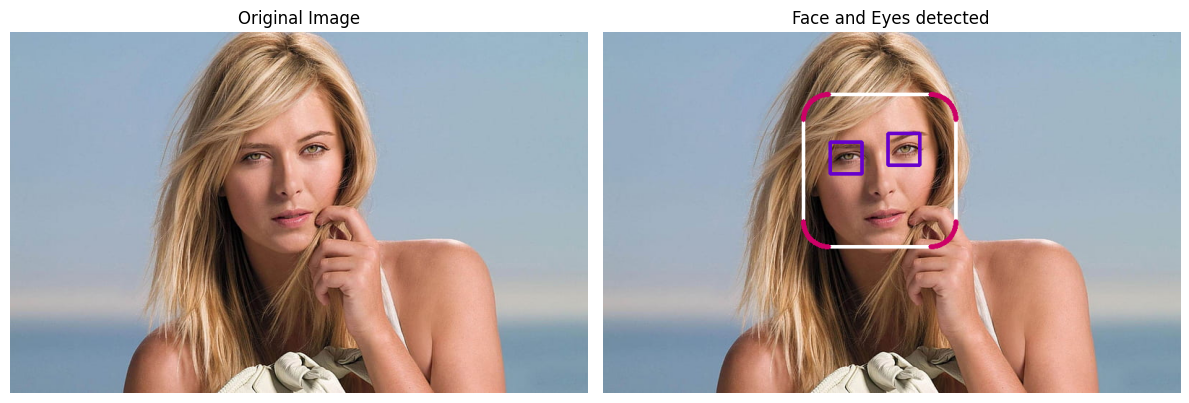

In [78]:
detect_face_and_eye("DATA/IMAGES/raw_images/sarapova_1.jpg")
detect_face_and_eye_1("DATA/IMAGES/raw_images/sarapova_1.jpg", save_fig=True, filename="sarapova_eyes.jpg")

# Human full body detection

## Body Detection from image

Number of bodies detected: 3
Body 1 detected at (1675, 850, 1732, 965)
Body 2 detected at (2786, 875, 3257, 1816)
Body 3 detected at (3254, 802, 3766, 1826)
Saved image with detections to DATA/IMAGES/detected_images\body_detection.jpg


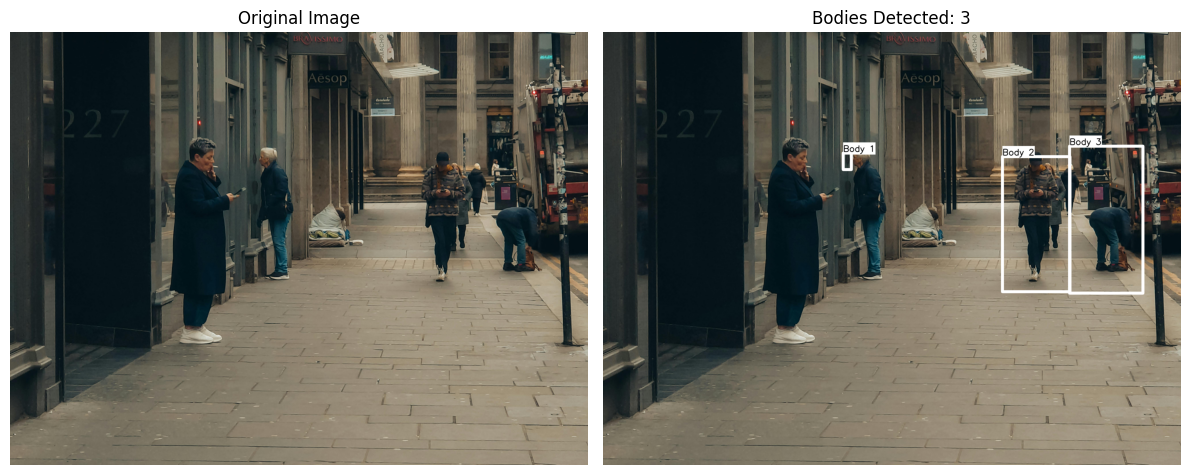

In [136]:

def detect_human_body(image_path, scale_factor, min_neighbours, save_fig=False, filename=None):
    try:
        # Correct path to the full-body Haar cascade
        fullbody_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_fullbody.xml')
        if fullbody_cascade.empty():
            raise Exception("Error loading full body cascade classifier!")

        # Handle image input (URL or local path)
        if image_path.startswith(('https', 'http')):
            try:
                response = requests.get(image_path)
                if response.status_code != 200 or not response.content:
                    raise Exception(f"Failed to fetch image from the web. Status code: {response.status_code}")
                
                # Convert response content to image
                image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
                img = cv.imdecode(image_array, cv.IMREAD_COLOR)
                if img is None:
                    raise Exception("Error decoding the image from URL.")
            except requests.exceptions.RequestException as req_err:
                print(f"Error fetching image: {req_err}")
                return
        else:
            img = cv.imread(image_path)
            if img is None:
                raise FileNotFoundError(f"Failed to load image from local path: {image_path}")
        
        # Convert image to RGB and grayscale
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_rgb_copy = img_rgb.copy()
        thickness = max(1, int(img.shape[1] / 200))

        # Detect human bodies
        body_coords = fullbody_cascade.detectMultiScale(img_gray, 
                                                        scaleFactor=scale_factor,
                                                        minNeighbors=min_neighbours)

        print(f"Number of bodies detected: {len(body_coords)}")

        if len(body_coords) > 0:
            body_count = 1
            for (bx, by, bw, bh) in body_coords:
                try:
                    # Draw rectangles and labels
                    cv.rectangle(img_rgb, (bx, by), (bx + bw, by + bh), (255, 255, 255), thickness)
                    label = f"Body {body_count}"
                    draw_text_with_bg(img_rgb, label, (bx, by - 10), font_scale=2, thickness=3)
                    print(f"Body {body_count} detected at ({bx}, {by}, {bx + bw}, {by + bh})")
                    body_count += 1
                except Exception as e:
                    print(f"Error processing body {body_count}: {e}")
        else:
            print("No bodies detected.")

        # Plot the original and detected images
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img_rgb_copy)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(img_rgb)
        ax[1].set_title(f'Bodies Detected: {len(body_coords)}' if len(body_coords) > 0 else 'No Bodies Detected')
        ax[1].axis('off')

        if save_fig and filename:
            try:
                # Ensure the folder exists
                save_dir = "DATA/IMAGES/detected_images"
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)

                filepath = os.path.join(save_dir, filename)
                fig.savefig(filepath, bbox_inches='tight', dpi=200)
                print(f"Saved image with detections to {filepath}")
            except Exception as e:
                print(f"Error saving file: {e}")

        plt.tight_layout()
        plt.show()

    except FileNotFoundError as fnf_error:
        print(f"File not found: {fnf_error}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Call the function
detect_human_body("https://images.pexels.com/photos/28957602/pexels-photo-28957602/free-photo-of-busy-urban-street-scene-in-glasgow-city-center.jpeg",
                  1.1, 3, save_fig=True, filename="body_detection.jpg")



Number of bodies detected: 3
Body 1 detected at (1134, 320, 1290, 632)
Body 2 detected at (150, 1293, 750, 2492)
Body 3 detected at (559, 1472, 1083, 2519)
Saved image with detections to DATA/IMAGES/detected_images\body_detection_1.jpg


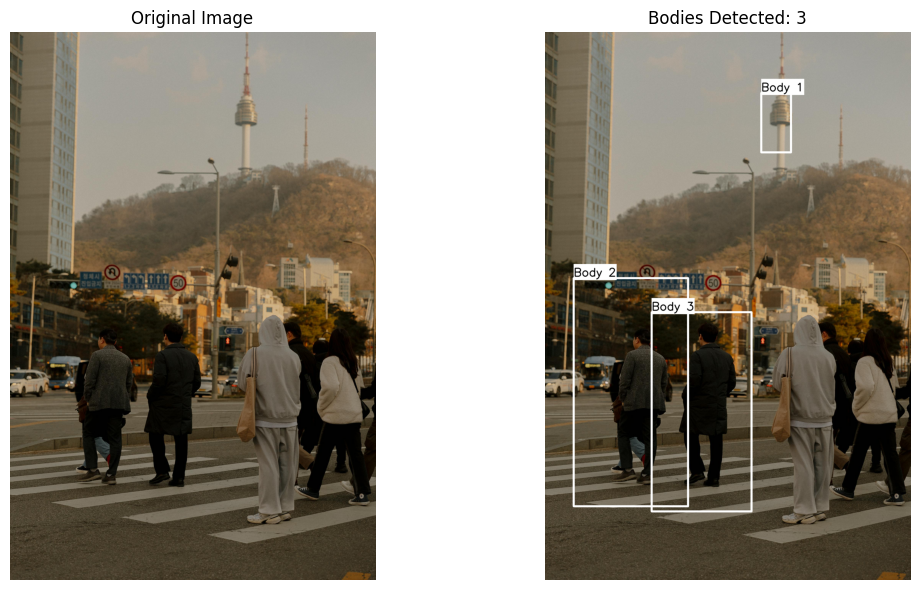

In [120]:
detect_human_body("DATA/IMAGES/raw_images/people_on_streets_2.jpg" , 1.1, 5, save_fig=True, filename='body_detection_1.jpg')

Number of bodies detected: 7
Body 1 detected at (1096, 1028, 1141, 1117)
Body 2 detected at (135, 987, 184, 1084)
Body 3 detected at (654, 470, 711, 584)
Body 4 detected at (1077, 686, 1262, 1055)
Body 5 detected at (815, 738, 857, 822)
Body 6 detected at (1587, 758, 1713, 1009)
Body 7 detected at (348, 690, 595, 1184)
Saved image with detections to DATA/IMAGES/detected_images\body_detection_2.jpg


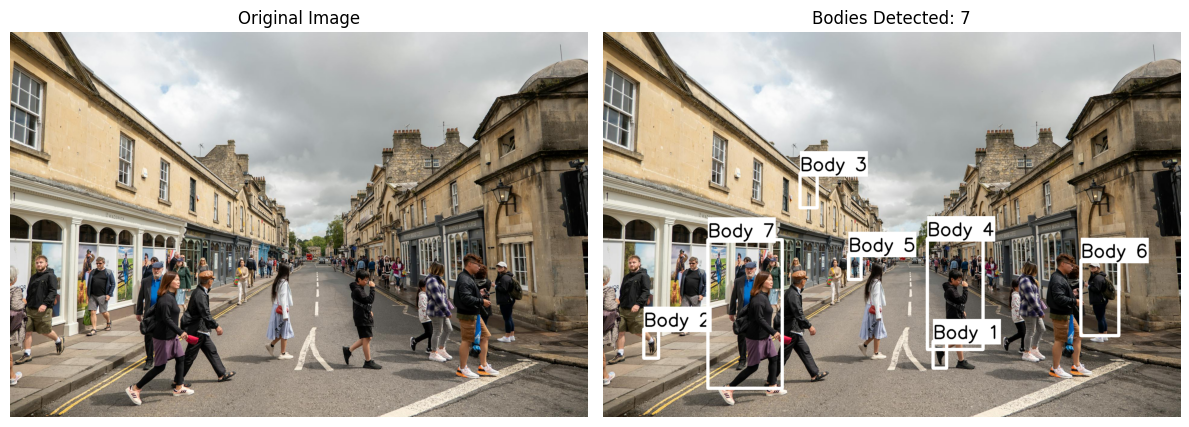

In [121]:
detect_human_body("DATA/IMAGES/raw_images/people_on_streets.jpg", 1.05, 3, save_fig=True, filename='body_detection_2.jpg')

## Body detection from videos

In [134]:

def detect_human_body_from_video(video_path, scale_factor, min_neighbors, resize_factor, save_video=False, filename=None):
    try:
        # Load full-body Haar cascade
        fullbody_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_fullbody.xml')
        if fullbody_cascade.empty():
            raise Exception("Error loading full-body cascade classifier!")

        # Open the video file
        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            raise FileNotFoundError(f"Error: Couldn't open the video at {video_path}!")

        # Get video properties: width, height, and FPS
        f_w, f_h, fps = (int(cap.get(x)) for x in (cv.CAP_PROP_FRAME_WIDTH, cv.CAP_PROP_FRAME_HEIGHT, cv.CAP_PROP_FPS))

        video_dir = "DATA/VIDEOS/detected_videos"
        output = None

        # Prepare to save video if requested
        if save_video and filename:
            try:
                if not os.path.exists(video_dir):
                    os.makedirs(video_dir)  # Ensure the save directory exists

                save_video_path = os.path.join(video_dir, filename)
                fourcc = cv.VideoWriter_fourcc(*"mp4v")
                output = cv.VideoWriter(save_video_path, fourcc, fps, (f_w, f_h))
            except Exception as e:
                print(f"Error preparing video writer: {e}")
                raise

        # Process video frames
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("End of video stream or error reading frame.")
                break

            # Convert frame to grayscale
            frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

            # Detect human bodies in the current frame
            body_coords = fullbody_cascade.detectMultiScale(frame_gray, scaleFactor=scale_factor, minNeighbors=min_neighbors)

            if len(body_coords) > 0:
                body_count = 1
                for (x, y, w, h) in body_coords:
                    try:
                        # Draw rectangle around detected bodies
                        cv.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 4)
                        label = f"Body_{body_count}"
                        draw_text_with_bg(frame, label, (x, y - 10), font_scale=0.75, thickness=2)
                        body_count += 1
                    except Exception as e:
                        print(f"Error processing body {body_count}: {e}")

            # Write the processed frame to the output video
            if save_video and output:
                output.write(frame)

            # Resize the frame for display
            resized_frame = cv.resize(frame, (int(resize_factor * frame.shape[1]), int(resize_factor * frame.shape[0])))
            cv.imshow('Video', resized_frame)

            # Break if the 'p' key is pressed
            if cv.waitKey(1) & 0xFF == ord('p'):
                print("Video paused/stopped by user.")
                break

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Release video capture and writer resources
        if cap:
            cap.release()
        if save_video and output:
            output.release()
        cv.destroyAllWindows()
        print("Video processing complete.")



In [126]:
detect_human_body_from_video("https://videos.pexels.com/video-files/1596860/1596860-sd_640_360_30fps.mp4",
                             1.1, 3, 1)

In [135]:
detect_human_body_from_video("https://videos.pexels.com/video-files/855789/855789-hd_1920_1080_30fps.mp4",
                             1.1, 3, 0.5, save_video=True, filename='body_detection_vid.mp4')

End of video stream or error reading frame.
Video processing complete.
